# Data Modelling

In this part I was trying to find the best solution for my prediction model. To get started, I needed to import all necessary libraries and files. I also turned warnings off just like in the previous Notebook:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings


from joblib import dump, load

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor

from Classes_And_Functions import *


In [2]:
warnings.filterwarnings('ignore')

I loaded the original data in an unchanged form:

In [3]:
df = pd.read_csv('data/listings_full.csv')

In [4]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20191204162729,2019-12-07,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",none,Centrally located in the heart of Manhattan ju...,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.39
1,3831,https://www.airbnb.com/rooms/3831,20191204162729,2019-12-07,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,f,moderate,f,f,1,1,0,0,4.67
2,5099,https://www.airbnb.com/rooms/5099,20191204162729,2019-12-06,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment has a true New Yo...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment has a true New Yo...,none,My neighborhood in Midtown East is called Murr...,...,f,f,moderate,t,t,1,1,0,0,0.60
3,5121,https://www.airbnb.com/rooms/5121,20191204162729,2019-12-06,BlissArtsSpace!,NaN,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,0.38
4,5178,https://www.airbnb.com/rooms/5178,20191204162729,2019-12-05,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"You will use one large, furnished, private roo...",Please don’t expect the luxury here just a bas...,none,"Theater district, many restaurants around here.",...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,3.52


Since the original dataset does not have **log_price** column by default, I had to perform similar operations as in Part 1 to get this feature and remove **price** column completely: 

In [5]:
df['price'] = df['price'].apply(lambda x: remove_nonnumeric_chars(x))
df['price'] = df['price'].astype('float')
df['log_price'] = df['price'].apply(lambda x: np.log(x+1))
df.drop(columns=['price'], inplace=True)

After getting **log_price** feature, I could divide the whole dataset to target feature *y* which is **log_price** and the predictor variables called *X*.

In [6]:
y = df['log_price']
X = df.drop(columns=['log_price'])

Using Scikit-learn built-in *train_test_split* function, I divided my data into train and validation set. The first one was used to fit all possible models. The second was used to see how all fitted estimators predicted **log_price** on a data the model had not seen before.

I decided to make the validation set with 20% of my training data and keep the rest as my train set:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

I retrieved *columns_to_remove* list as well as loaded *preprocessing_pipeline* .joblib file from *01_Data_processing* Notebook and transformed both train set and validation set with this pipeline. I have transformed both sets separately as to avoid 'data leakage':

In [8]:
columns_to_remove = ['last_review',
 'calendar_last_scraped',
 'reviews_per_month',
 'bed_type',
 'availability_30',
 'notes',
 'neighbourhood',
 'room_type',
 'country_code',
 'first_review',
 'calendar_updated',
 'street',
 'host_total_listings_count',
 'host_acceptance_rate',
 'scrape_id',
 'calculated_host_listings_count_private_rooms',
 'host_picture_url',
 'is_business_travel_ready',
 'host_response_rate',
 'experiences_offered',
 'minimum_minimum_nights',
 'maximum_maximum_nights',
 'market',
 'host_is_superhost',
 'availability_60',
 'picture_url',
 'host_response_time',
 'require_guest_profile_picture',
 'interaction',
 'host_url',
 'host_neighbourhood',
 'host_location',
 'review_scores_accuracy',
 'thumbnail_url',
 'maximum_nights',
 'summary',
 'has_availability',
 'number_of_reviews_ltm',
 'city',
 'name',
 'amenities',
 'neighbourhood_group_cleansed',
 'host_thumbnail_url',
 'access',
 'host_name',
 'minimum_nights',
 'host_verifications',
 'maximum_minimum_nights',
 'jurisdiction_names',
 'neighbourhood_cleansed',
 'last_scraped',
 'maximum_nights_avg_ntm',
 'host_about',
 'property_type',
 'listing_url',
 'minimum_nights_avg_ntm',
 'host_listings_count',
 'availability_90',
 'description',
 'house_rules',
 'state',
 'medium_url',
 'space',
 'calculated_host_listings_count_shared_rooms',
 'id',
 'host_has_profile_pic',
 'smart_location',
 'neighborhood_overview',
 'minimum_maximum_nights',
 'review_scores_value',
 'host_id',
 'country',
 'requires_license',
 'review_scores_communication',
 'weekly_price',
 'calculated_host_listings_count_entire_homes',
 'xl_picture_url',
 'is_location_exact',
 'transit',
 'monthly_price',
 'review_scores_checkin',
 'license',
 'require_guest_phone_verification',
 'zipcode',
 'host_since',
 'review_scores_cleanliness',
 'square_feet']

data_compiled_date = pd.Timestamp(2019, 12, 8)
preprocessing_pipeline = load('preprocessing_pipeline.joblib')

In [9]:
X_train = preprocessing_pipeline.fit_transform(X_train)
X_test = preprocessing_pipeline.fit_transform(X_test)

X_train_preprocessed = X_train
X_test_preprocessed = X_test

Having both sets cleaned and prepared for modelling, I was able to start looking for a best possible model for predicting Airbnb listing's price. 

In order to maintain the modelling process, I saved train set and validation set after preprocessing transformations to *X_train_preprocessed* and *X_test_preprocessed* variables. Thanks to that, I would be able to quickly retrieve train set and validation set to the "after-preprocessing" stage whereas modyfing the preprocessed sets with scaling or other methods.

## Model research

To find a best suitable predictor for the listing's price, I have decided to go through a couple of options of data representation, choose the one model that worked best and apply the best solution to the test set that is going to be introduced in Part 3 of this project.

To measure which predictor is the best one, I have chosen MSE (Mean Squared Error) as my main metrics. Each model taken into consideration was fitted on the train set, then the fitted estimator predicted values for both train and the validation set to get 'training error' and 'test error' and displayed information about R2 and MSE metrics. When I was looking for the best solution not only did I look at MSE itself. I also took into account the R2 metrics as well as difference between training and test error to claim if certain estimator tends to overfitting.

### Model "zero"

To have some reference at start, I took my preprocessed data and fitted them in the simple model. As a model "zero" I have chosen LinearRegression().

In [10]:
model_0 = LinearRegression()
model_0.fit(X_train, y_train)

y_pred_train = model_0.predict(X_train)
r2_train = metrics.r2_score(y_true=y_train, y_pred=y_pred_train)
mse_train = metrics.mean_squared_error(y_true=y_train, y_pred=y_pred_train)

y_pred = model_0.predict(X_test)
r2 = metrics.r2_score(y_true=y_test, y_pred=y_pred)
mse = metrics.mean_squared_error(y_true=y_test, y_pred=y_pred)

print(f'Model 0: \n Train dataset prediction results: -R2:{r2_train}, MSE: {mse_train}\n')
print(f' Test dataset prediction results:  -R2:{r2}, MSE: {mse}\n')


Model 0: 
 Train dataset prediction results: -R2:0.572023279949442, MSE: 0.2135125283409154

 Test dataset prediction results:  -R2:0.570408176106705, MSE: 0.21271287069582728



## Data representation options

### Models template

At this stage, I wanted to go through different combinations of data premodelling and tested the same estimators for each solution so I created *get_best_models* function which takes both train and validation set and actual **log_price** values as arguments. 

The function performs fitting on set of models I had chosen and predicts **log_price** with usage of best fitted estimators. 

Finally, the function returns *results* Dataframe containing prediction results (R2 and MAE metrics for both, train and validation set) for each estimator and *estimators* - list of best fitted estimators.  

For 'models template' I have chosen:
+ Linear Regression - grid-searched
+ ElasticNet - grid-searched
+ Lasso - grid-searched
+ Decision Tree Regressor - grid-searched
+ Random Forest Regressor - default model
+ Voting Regressor - combination of 5 first models
+ Gradient Boosting Regressor - default model


In [11]:
def get_best_models(X_train, X_test, y_train, y_test):
    
    kfold = KFold(n_splits=5, random_state=123)
    
    grid_1 = GridSearchCV(make_pipeline(PolynomialFeatures(), LinearRegression()),
                    param_grid={'polynomialfeatures__degree': [1, 2]},
                    cv=kfold,
                    refit=True)
    grid_1.fit(X_train, y_train)
    
    
    grid_2 = GridSearchCV(make_pipeline(PolynomialFeatures(), ElasticNet()),
                        param_grid={'polynomialfeatures__degree': [1, 2],
                        'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
                        cv=kfold,
                        refit=True)
    grid_2.fit(X_train, y_train)
    
    grid_3 = GridSearchCV(make_pipeline(PolynomialFeatures(), Lasso()),
                        param_grid={'polynomialfeatures__degree': [1, 2],
                        'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
                        cv=kfold,
                        refit=True)
    grid_3.fit(X_train, y_train)
    
    grid_4 = GridSearchCV(make_pipeline(PolynomialFeatures(), DecisionTreeRegressor()),
                        param_grid={'polynomialfeatures__degree': [1, 2],
                                    'decisiontreeregressor__splitter': ['best', 'random'],
                                    'decisiontreeregressor__max_depth': [4, 8, 10]},
                        cv=kfold,
                        refit=True)
    
    
    grid_4.fit(X_train, y_train)
   
    
    model_5 = RandomForestRegressor()
    model_5.fit(X_train, y_train)
    
    model_6 = VotingRegressor([
        ('LR', grid_1.best_estimator_), 
        ('ElasticNet', grid_2.best_estimator_), 
        ('Lasso', grid_3.best_estimator_), 
        ('Decision Tree', grid_4.best_estimator_),
        ('Random Forest Regressor', model_5)])
    model_6.fit(X_train, y_train)
    
    model_7 = GradientBoostingRegressor()
    model_7.fit(X_train, y_train)
    
    models = [
        ('Linear Regression', grid_1.best_estimator_),
        ('ElasticNet', grid_2.best_estimator_),
        ('Lasso', grid_3.best_estimator_),
        ('Decision Tree Regressor', grid_4.best_estimator_),
        ('Random Forest Regressor', model_5),
        ('Voting Regressor', model_6),
        ('Gradient Boosting Regressor', model_7)
        
    ]
    
    estimators = []
   
    
    results = pd.DataFrame(columns=['Model', 'R2 train', 'MSE train', 'R2 test', 'MSE test'])
    
    for name, model in models:
        
        estimators.append(model)
        
        y_pred_train = model.predict(X_train)
        r2_train = metrics.r2_score(y_true=y_train, y_pred=y_pred_train)
        mse_train = metrics.mean_squared_error(y_true=y_train, y_pred=y_pred_train)
        
        y_pred = model.predict(X_test)
        r2 = metrics.r2_score(y_true=y_test, y_pred=y_pred)
        mse = metrics.mean_squared_error(y_true=y_test, y_pred=y_pred)
        
        row = pd.Series(data=[name, r2_train, mse_train, r2, mse], index=results.columns.tolist())
        results = results.append(row, ignore_index=True)
        
    
    return [results, estimators]

### Dimensionality reduction

In [12]:
len(X_train.columns)

39

As my preprocessed dataset consisted of 39 predictor variables, I tried decreasing number of features to improve future model's performances. One of the ways I achieved that was using Principal Component Analysis algorithm. 

PCA takes original features within dataset and transforms them, therefore, creating completely new variables, orthogonal to each other. It does it in such a way it keeps relevant information (variance) while decreasing number of features at the same time.

However, PCA requires data scaling because if certain features have different ranges of values, then i.e. the ones with higher scale have a bigger variance which blurs PCA results.

As I could not find the one right answer on what scaler to choose to perform PCA, I have decided to go on with *MinMaxScaler* and *StandardScaler* and compare the results.

In [13]:
mms = MinMaxScaler()
X_train_mms = mms.fit_transform(X_train)

To see how many components I have to take to perform PCA I made a plot, showing number of features related to percentage of explained variance.
I put lines on number of components for the percentages of variance I was going to try out:

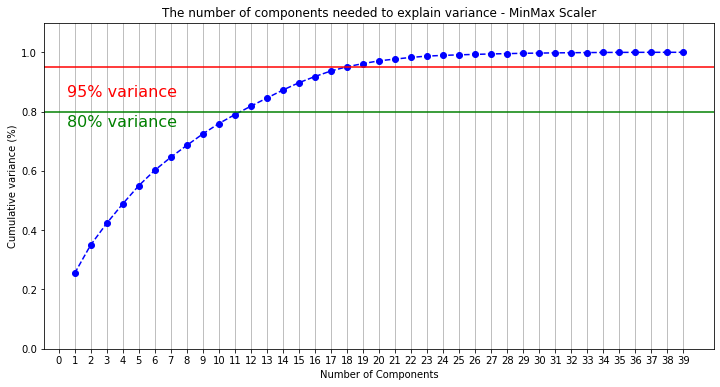

In [14]:
pca = PCA().fit(X_train_mms)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 40, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 40, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance - MinMax Scaler')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.axhline(y=0.8, color='g', linestyle='-')


plt.text(0.5, 0.85, '95% variance', color = 'red', fontsize=16)
plt.text(0.5, 0.75, '80% variance', color = 'green', fontsize=16)

ax.grid(axis='x')
plt.show()

### MinMaxScaler + PCA(20)

According to the plot, in order to have 95% explained variance on MinMaxScaled data I needed to take 20 components while using PCA, so I have created a *premodelling_pipeline* where the train set is scaled with *MinMaxScaler* and treated with PCA with 20 components.

In [15]:
premodelling_pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=20))
])

X_train_premodelled = premodelling_pipeline.fit_transform(X_train)
X_test_premodelled = premodelling_pipeline.transform(X_test)

In [16]:
minmax_pca_20_results, minmax_pca_20_estimators = get_best_models(X_train_premodelled, X_test_premodelled, y_train, y_test)

print('Results: ')
minmax_pca_20_results

Results: 


,Model,R2 train,MSE train,R2 test,MSE test
0,Linear Regression,0.530215,0.234370,0.527411,0.234003
1,ElasticNet,0.516395,0.241265,0.515253,0.240023
2,Lasso,0.510229,0.244341,0.509429,0.242907
3,Decision Tree Regressor,0.473978,0.262426,0.393411,0.300353
4,Random Forest Regressor,0.929142,0.035350,0.490830,0.252116
5,Voting Regressor,0.651403,0.173911,0.530054,0.232694
6,Gradient Boosting Regressor,0.492886,0.252993,0.468325,0.263259


This solution was not very satisfying.

All models performed worse than "model 0" except for *VotingRegressor* and *RandomForestRegressor* which happened to predict **log_price** on a training set better, but a model which can predict only the data it had seen before is definitely not a good one!

### MinMaxScaler + PCA ( 12)

Seeing not good results for using PCA with 20 components, I decided to go with the same approach but this time implementing PCA with 12 components which would keep 80% of variance according to the plot generated before:

In [17]:
#reset X_train, X_test
X_train = X_train_preprocessed
X_test = X_test_preprocessed

In [18]:
premodelling_pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=12))
])

X_train_premodelled = premodelling_pipeline.fit_transform(X_train)
X_test_premodelled = premodelling_pipeline.transform(X_test)

minmax_pca_12_results, minmax_pca_12_estimators = get_best_models(X_train_premodelled, X_test_premodelled, y_train, y_test)

print('Results: ')
minmax_pca_12_results

Results: 


,Model,R2 train,MSE train,R2 test,MSE test
0,Linear Regression,0.438453,0.280149,0.439518,0.277523
1,ElasticNet,0.438412,0.280170,0.439335,0.277614
2,Lasso,0.438322,0.280215,0.439136,0.277712
3,Decision Tree Regressor,0.437286,0.280731,0.356368,0.318695
4,Random Forest Regressor,0.925763,0.037036,0.458879,0.267937
5,Voting Regressor,0.596939,0.201082,0.465081,0.264866
6,Gradient Boosting Regressor,0.447844,0.275464,0.420182,0.287097


Decreasing number of components made even worse results so I moved on to trying out PCA with StandardScaler

### Standard Scaler + PCA (29)

I made the same kind of plot I generated for min-max-scaled data:

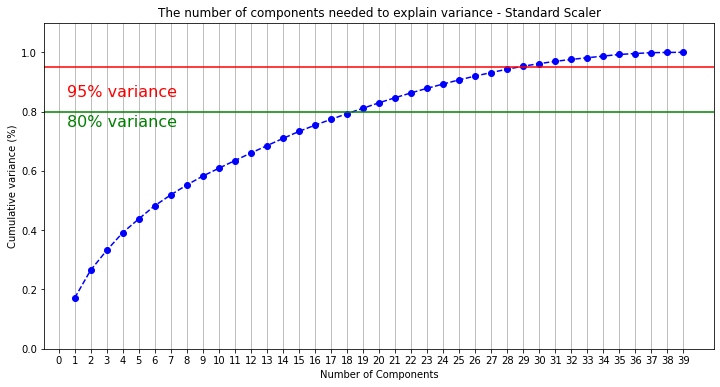

In [19]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)

pca = PCA().fit(X_train_sc)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 40, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 40, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance - Standard Scaler')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.axhline(y=0.8, color='g', linestyle='-')


plt.text(0.5, 0.85, '95% variance', color = 'red', fontsize=16)
plt.text(0.5, 0.75, '80% variance', color = 'green', fontsize=16)

ax.grid(axis='x')
plt.show()

The plot indicated that I needed 29 components for 95% explained variance ratio so I made a new *preprocessing_pipeline* in which both train and validation sets are scaled and treated with PCA with 29 components: 

In [20]:
X_train = X_train_preprocessed
X_test = X_test_preprocessed

premodelling_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=29))
])

X_train_premodelled = premodelling_pipeline.fit_transform(X_train)
X_test_premodelled = premodelling_pipeline.transform(X_test)

std_pca_29_results, std_pca_29_estimators = get_best_models(X_train_premodelled, X_test_premodelled, y_train, y_test)

print('Results: ')
std_pca_29_results

Results: 


,Model,R2 train,MSE train,R2 test,MSE test
0,Linear Regression,0.553377,0.222815,0.552809,0.221427
1,ElasticNet,0.649011,0.175104,0.628783,0.183809
2,Lasso,0.648911,0.175154,0.629278,0.183563
3,Decision Tree Regressor,0.577023,0.211018,0.489088,0.252979
4,Random Forest Regressor,0.947326,0.026278,0.627450,0.184468
5,Voting Regressor,0.732994,0.133206,0.633506,0.181470
6,Gradient Boosting Regressor,0.605642,0.196741,0.585609,0.205186


PCA on data scaled with *StandardScaler* definitely worked better! All models performances have increased. *RandomForestRegressor* is still overfitting. The best MSE score on validation data has *VotingRegressor* however *Elasticnet* and *Lasso* have just slightly higher MSE score with the lowest training-error test-error difference.

Since decreasing number of components gave worse results for min-max scaled data, I decided not to try PCA with 80% explained variance ratio on standarized sets.

### Pearson feature selection

I have also tried using Pearson correlation coefficient in *SelectKBest* on pure preprocessed data, to choose either 5, 10 or 20 best original features for my model:

In [21]:
pearson_data_representations = {}

for k in [5,10,20]:
    
    X_train = X_train_preprocessed
    X_test = X_test_preprocessed

    fs = SelectKBest(score_func=f_regression, k=k)

    X_train_premodelled = fs.fit_transform(X_train, y_train)
    X_test_premodelled = fs.transform(X_test)
    
    item = {str(k) : get_best_models(X_train_premodelled, X_test_premodelled, y_train, y_test)}
    pearson_data_representations.update(item)
    



In [22]:
print('RESULTS FOR 5 FEATURES SELECTED WITH PEARSON METHOD: ')
pearson_data_representations['5'][0]

RESULTS FOR 5 FEATURES SELECTED WITH PEARSON METHOD: 


,Model,R2 train,MSE train,R2 test,MSE test
0,Linear Regression,0.537900,0.230536,0.539840,0.227849
1,ElasticNet,0.537898,0.230537,0.539788,0.227875
2,Lasso,0.537896,0.230538,0.539750,0.227893
3,Decision Tree Regressor,0.566323,0.216356,0.548449,0.223586
4,Random Forest Regressor,0.615570,0.191788,0.544600,0.225492
5,Voting Regressor,0.572117,0.213466,0.556502,0.219598
6,Gradient Boosting Regressor,0.555419,0.221796,0.552202,0.221728


In [23]:
print('RESULTS FOR 10 FEATURES SELECTED WITH PEARSON METHOD: ')
pearson_data_representations['10'][0]

RESULTS FOR 10 FEATURES SELECTED WITH PEARSON METHOD: 


,Model,R2 train,MSE train,R2 test,MSE test
0,Linear Regression,0.590676,0.204207,0.593736,0.201162
1,ElasticNet,0.569058,0.214992,0.570042,0.212894
2,Lasso,0.569192,0.214925,0.570174,0.212829
3,Decision Tree Regressor,0.625130,0.187018,0.587627,0.204187
4,Random Forest Regressor,0.942786,0.028543,0.601702,0.197218
5,Voting Regressor,0.705896,0.146725,0.620897,0.187713
6,Gradient Boosting Regressor,0.618189,0.190481,0.615476,0.190397


In [24]:
print('RESULTS FOR 20 FEATURES SELECTED WITH PEARSON METHOD: ')
pearson_data_representations['20'][0]

RESULTS FOR 20 FEATURES SELECTED WITH PEARSON METHOD: 


,Model,R2 train,MSE train,R2 test,MSE test
0,Linear Regression,0.628132,0.185521,0.626037,0.185168
1,ElasticNet,0.595302,0.201899,0.594318,0.200874
2,Lasso,0.595263,0.201918,0.594385,0.200841
3,Decision Tree Regressor,0.659428,0.169907,0.623369,0.186489
4,Random Forest Regressor,0.956166,0.021868,0.701965,0.147572
5,Voting Regressor,0.736502,0.131456,0.665811,0.165474
6,Gradient Boosting Regressor,0.657020,0.171109,0.653974,0.171335


Using Pearson's feature selection, it turned out the higher number of features chosen with Pearson, the better models' general performance!

*VotingRegressor* and *GradientBoostingRegressor* were potential winners at this point. 

Despite of the fact that *VotingRegressor* had slightly lower MSE than *GradientBoostingRegressor*, the second one was better model in my opinion since the training and test error were virtually the same! 

*RandomForestRegressor* overfitted but the difference between training and test score has decreased though.


### Standard Scaler + all original features

Seeing that *StandardScaler* was more efficient when using PCA and increasing number of features was giving better results while using Pearson feature selection, I have decided to try using all original features of the preprocessed train set, scaled with *StandardScaler* before:

In [25]:
X_train = X_train_preprocessed
X_test = X_test_preprocessed

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train, y_train)
X_test_std = sc.transform(X_test)

std_results, std_estimators = get_best_models(X_train_std, X_test_std, y_train, y_test)

In [26]:
std_results

,Model,R2 train,MSE train,R2 test,MSE test
0,Linear Regression,0.572023,0.213513,0.570408,0.212713
1,ElasticNet,0.665658,0.166799,0.648674,0.173959
2,Lasso,0.668012,0.165625,0.645165,0.175697
3,Decision Tree Regressor,0.665918,0.166670,0.612729,0.191758
4,Random Forest Regressor,0.959331,0.020289,0.724116,0.136604
5,Voting Regressor,0.759523,0.119971,0.687923,0.154525
6,Gradient Boosting Regressor,0.680088,0.159601,0.676274,0.160293


That was the best solution I have found! 
I decided to pick *GradientBoostingRegressor* to be a model I would like to try on the test set! As I wrote before, maybe it was not a best solution in terms of MSE error on a validation set's predictions yet it was the estimator with the lowest training error-validation error difference!

### Chosen solution

I have saved the chosen model along with a proper scaler, to .joblib files to use it in the last part of this project:

In [27]:
chosen_model = std_estimators[6]
chosen_model

GradientBoostingRegressor()

In [28]:
dump(sc, 'scaler.joblib')
dump(chosen_model, 'model.joblib')

['model.joblib']

Finding a model process was finished. It was the time to check the chosen model on a real test set!